In [0]:
!pip install keras-metrics
!pip install sklearn

https://github.com/hasibzunair/uw-2/blob/master/codes/others/vgg_configurations.ipynb

In [0]:
import numpy as np
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt

import keras_metrics
from imgaug import augmenters as iaa

#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold


from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1)

Using TensorFlow backend.


In [0]:
!ls

sample_data


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [0]:
!ls

kaggle.json  sample_data


In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d hasibzunair/malaria

 98% 801M/815M [00:24<00:00, 37.2MB/s]
100% 815M/815M [00:24<00:00, 34.9MB/s]


In [0]:
!ls

kaggle.json  malaria.zip  sample_data


In [0]:
!unzip 'malaria.zip'

Archive:  malaria.zip
  inflating: y_test.npy              
  inflating: x_test.npy              
  inflating: y_train.npy             
  inflating: y_val.npy               
  inflating: x_train.npy             
  inflating: x_val.npy               


In [0]:
!ls

kaggle.json  sample_data  x_train.npy  y_test.npy   y_val.npy
malaria.zip  x_test.npy   x_val.npy    y_train.npy


In [0]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_train.shape, y_train.shape

((22046, 200, 200, 3), (22046, 2))

In [0]:
x_val = np.load("x_val.npy")
y_val = np.load("y_val.npy")
x_val.shape, y_val.shape

((2756, 200, 200, 3), (2756, 2))

In [0]:
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [0]:
img = x_train[50]
img.shape

(200, 200, 3)

In [0]:
print(x_train.shape, y_train.shape)
print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2)
(2756, 200, 200, 3) (2756, 200, 200, 3) (2756, 2) (2756, 2)


In [0]:
IMAGE_SIZE = x_train.shape[1]
IMAGE_SIZE

200

In [0]:
# model with only the SOFTMAX layer frozen, unconventional wisdom kicks in!
def get_model_exp2_b():
    base_model = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model.trainable = False
    X = base_model.output
    X.trainable = False
    
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.5)(X)
    predictions = Dense(2, activation='softmax', trainable=False)(X)
    
    # this was before
    # predictions = Dense(2, activation='softmax',trainable=False)(X)
    
    for layer in base_model.layers[-4:]:
        layer.trainable=False
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = None
model=get_model_exp2_b()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 5s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
______________________

In [0]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2) (2756, 200, 200, 3) (2756, 2) (2756, 200, 200, 3) (2756, 2)


In [0]:
!rm -f "vgg16_2b.h5"

In [0]:
!ls

kaggle.json  sample_data  x_train.npy  y_test.npy   y_val.npy
malaria.zip  x_test.npy   x_val.npy    y_train.npy


In [0]:
model=get_model_exp2_b()
path_model='vgg16_2b.h5'  

# set the learning rate
K.set_value(model.optimizer.lr, 0.01) 

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=128, 
            epochs=50, 
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )



Instructions for updating:
Use tf.cast instead.
Train on 22046 samples, validate on 2756 samples
Epoch 1/50
22046/22046 [==============================] - 535s 24ms/step - loss: 0.2339 - acc: 0.9233 - val_loss: 0.1329 - val_acc: 0.9623
Epoch 2/50
22046/22046 [==============================] - 501s 23ms/step - loss: 0.1284 - acc: 0.9577 - val_loss: 0.1070 - val_acc: 0.9655
Epoch 3/50
22046/22046 [==============================] - 501s 23ms/step - loss: 0.1115 - acc: 0.9615 - val_loss: 0.1162 - val_acc: 0.9612
Epoch 4/50
22046/22046 [==============================] - 501s 23ms/step - loss: 0.1026 - acc: 0.9653 - val_loss: 0.1325 - val_acc: 0.9626
Epoch 5/50
22046/22046 [==============================] - 501s 23ms/step - loss: 0.0955 - acc: 0.9664 - val_loss: 0.0947 - val_acc: 0.9677
Epoch 6/50
22046/22046 [==============================] - 501s 23ms/step - loss: 0.0873 - acc: 0.9694 - val_loss: 0.0946 - val_acc: 0.9699
Epoch 7/50
22046/22046 [==============================] - 501s 23ms/s

KeyboardInterrupt: ignored

In [0]:
# loss: 3.0371e-05 - acc: 1.0000 - val_loss: 0.2597 - val_acc: 0.9699 ---- lr = 0.01
# loss: 2.5907e-06 - acc: 1.0000 - val_loss: 0.2381 - val_acc: 0.9717 ----> lr=0.1
# loss: 5.0338e-06 - acc: 1.0000 - val_loss: 0.2631 - val_acc: 0.9713  ----> lr=0.15
# loss: 0.1247 - acc: 0.9581 - val_loss: 0.1288 - val_acc: 0.9565 ---> lr=0.0001

In [0]:
#precision = keras_metrics.precision()
#recall = keras_metrics.recall()
#f1 = keras_metrics.f1_score()

#metrics=[precision, recall, f1, 'acc']

In [0]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()
    plt.show()

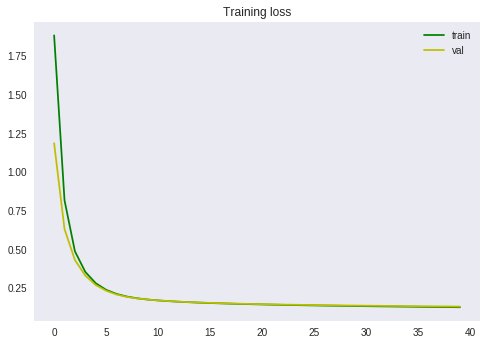

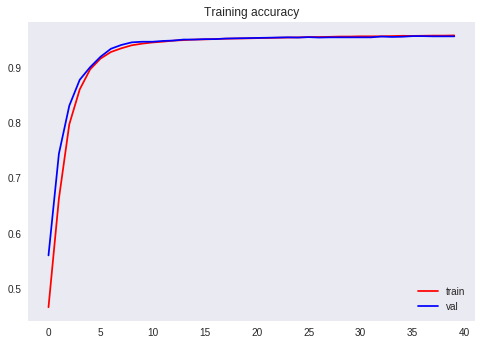

In [0]:
plot_loss_accu(h)

In [0]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2756/2756 [==============================] - 25s 9ms/step
Test loss: 0.21751629724391125
Test accuracy: 0.9677068214804064


| Experiments | Train | Val  | Test | Others 
|------|------|------|------|------|
|   1a   | 93.58| 93.94   | 93.57  |  Train on last layer
|   VGG   | xx | xx  | 96.33  | lr=0.2
|   VGG   | xx| xx   | xx  | 

In [0]:
def accuracy(x_test):
  y_pred = model.predict(x_test)
  # get labels from predictions
  pred_labels = np.array([np.argmax(pred) for pred in y_pred])
  #convert ground truths to column values
  y_test = np.argmax(y_test, axis=1)
  accuracy = np.mean((y_test==pred_labels)))
  return accuracy

def evaluate_error(x_test):
    pred = model.predict(x_test, batch_size = 32)
    pred = np.argmax(pred, axis=1)
    pred = np.expand_dims(pred, axis=1) # make same shape as y_test
    error = np.sum(np.not_equal(pred, y_test)) / y_test.shape[0]  
    return error
  

(2756, 2)

In [0]:
y_pred = model.predict(x_test)
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])
#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
accuracy = np.mean((y_test==pred_labels))


In [0]:
accuracy

0.9677068214804064

In [0]:
!mkdir files

In [0]:
!ls

files	     malaria.zip  vgg16_2b.h5  x_train.npy  y_test.npy	 y_val.npy
kaggle.json  sample_data  x_test.npy   x_val.npy    y_train.npy


In [0]:
pred_labels.shape

(2756,)

In [0]:
!os.listdir("files/")

/bin/bash: -c: line 0: syntax error near unexpected token `"files/"'
/bin/bash: -c: line 0: `os.listdir("files/")'


In [0]:
np.save("pred_labels.npy",pred_labels)
!ls

files	     malaria.zip      sample_data  x_test.npy	x_val.npy   y_train.npy
kaggle.json  pred_labels.npy  vgg16_2b.h5  x_train.npy	y_test.npy  y_val.npy


In [0]:
!cp pred_labels.npy files
!cp vgg16_2b.h5 files

In [0]:
# zip folder
!zip -r files.zip files

  adding: files/ (stored 0%)
  adding: files/vgg16_2b.h5 (deflated 7%)
  adding: files/pred_labels.npy (deflated 96%)


In [0]:
!ls

files	     malaria.zip      vgg16_2b.h5  x_val.npy	y_val.npy
files.zip    pred_labels.npy  x_test.npy   y_test.npy
kaggle.json  sample_data      x_train.npy  y_train.npy


In [0]:
from google.colab import files
files.download('files.zip') 

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 48340, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

### Test of time

In [0]:
x_test.shape

(2756, 200, 200, 3)

In [0]:
# standard augment 
seq1 = iaa.Sequential([
    iaa.Crop(px=(0, 16)), 
    iaa.Fliplr(0.5), 
    iaa.GaussianBlur(sigma=(0, 3.0))
])

# new augment
seq2 = iaa.Sequential([
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sometimes(0.7, 
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)
    ),
    iaa.Affine(
        rotate=(-25, 25),
    ),
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    ),
    iaa.Affine(
        shear=(-25, 25)
    ),
    
    #iaa.Sometimes(0.8, 
     #   iaa.CoarseDropout(0.03, size_percent=0.1)
    #),
], random_order=True) # apply augmenters in random order



seq3 = iaa.Sequential([
    iaa.ContrastNormalization((0.5, 1.5)),
    
    iaa.Crop(percent=(0, 0.2)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sometimes(0.7, 
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)
    ),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    #iaa.Multiply((0.8, 1.2), per_channel=0.2),
    
    iaa.Affine(
        rotate=(-25, 25),
    ),
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    ),
    iaa.Affine(
        shear=(-25, 25)
    ),
    
    iaa.Sometimes(0.8, 
        iaa.CoarseDropout(0.03, size_percent=0.1)
    ),
    iaa.Sequential([
        iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
        iaa.WithChannels(0, iaa.Add((50, 100))),
        iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")
    ]),
    
    
], random_order=True) # apply augmenters in random order


seq4 = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
         scale={"x": (0.6, 1.2), "y": (0.6, 1.2)},
     ),
    iaa.CoarseDropout((0.0, 0.1), size_percent=(0.02, 0.2)),
    
    iaa.Sometimes( 0.8, iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5)),
    
], random_order=True) # apply augmenters in random order


seq5 = iaa.Sequential([
    
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255)),
    
    iaa.Sometimes( 0.4, iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5)),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    #iaa.Multiply((0.8, 1.2), per_channel=0.2),
    
    iaa.Affine(
        rotate=(-90, 90),
    ),
    iaa.Affine(
        translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)},
    ),
    iaa.Affine(
        shear=(-50, 50)
    ),
    
    iaa.Sometimes(0.8, 
        iaa.CoarseDropout(0.03, size_percent=0.10)
    ),   
    
    iaa.ContrastNormalization((0.3, 1.8))
], random_order=True) # apply augmenters in random order

In [0]:
RESIZE_DIM = 200

# test time augmentation
def test_of_time(x_test):
  '''
  Arg: x_test: number of test samples of shape (N, w,h,3)
  Returns the predicted labels using test time augmentation    
  '''
  pred_label = []
  label = []
  # number of samples in test set
  l = len(x_test)
  for i in range(l):
      # normal sample
      img = x_test[i]
      
      # augmented sample reshaped(seq acceptd rank-4 tensor) and fed to sequences
      img_a = seq1.augment_images(img.reshape(1,RESIZE_DIM,RESIZE_DIM,3))
      img_b = seq2.augment_images(img.reshape(1,RESIZE_DIM,RESIZE_DIM,3))
      
      img_c = seq3.augment_images(img.reshape(1,RESIZE_DIM,RESIZE_DIM,3))
      img_d = seq4.augment_images(img.reshape(1,RESIZE_DIM,RESIZE_DIM,3))
      

      # augmented sample reshaped back in normal(rank-3 tensor)
      img_a_out = img_a.reshape(RESIZE_DIM,RESIZE_DIM,3)
      img_b_out = img_b.reshape(RESIZE_DIM,RESIZE_DIM,3)
      
      img_c_out = img_c.reshape(RESIZE_DIM,RESIZE_DIM,3)
      img_d_out = img_d.reshape(RESIZE_DIM,RESIZE_DIM,3)
      

      # test of time!
      y_test1 = model.predict(img_a_out[None,:,:,:])
      y_test2 = model.predict(img_b_out[None,:,:,:])
      
      y_test3 = model.predict(img_c_out[None,:,:,:])
      y_test4 = model.predict(img_d_out[None,:,:,:])
      y_test5 = model.predict(img[None,:,:,:])

      # change the params in the weighted average equation for minor changes in the performance
      # future works: arithmetic mean

      # coefficients should add up to 1!
      #y_test = .2*y_test1 + .2*y_test2 + .2*y_test3 + .4*y_test4
      
      y_test = .2*y_test1 + .2*y_test2 + .2*y_test3 + .2*y_test4 + .2*y_test5
      label.append(y_test)

  # convert to final predicted labels
  pred_labels=np.concatenate(label)
  return pred_labels

In [0]:
label_pred = None
label_pred = test_of_time(x_test)
label_pred.shape

(2756, 2)

In [0]:
# for tta
labels= np.array([np.argmax(pred) for pred in label_pred])
labels.shape

(2756,)

In [0]:
# check shape for ground truth and predicted labels: (N,)
y_test.shape, labels.shape

((2756,), (2756,))

In [0]:
print('Accuracy with TTA: ',np.mean((y_test==labels)))

Accuracy with TTA:  0.9524673439767779


In [0]:
print('Accuracy without TTA: ',np.mean((y_test==pred_labels)))

Accuracy without TTA:  0.9677068214804064


In [0]:
def pad_image_for_square( img ):
    (rows, cols, dim) = img.shape
    resize_dim = max( rows, cols)
    pad_row = resize_dim - rows
    pad_col = resize_dim - cols
    img = np.pad(img, ((0,pad_row), (0, pad_col), (0,0)), 'constant', constant_values=0)
    return img